# Permasalahan atau Informasi yang Ingin Didapatkan

Permasalahan utama dalam proyek ini adalah bagaimana cara **mengidentifikasi dan mengklasifikasikan sentimen dalam ulasan film secara otomatis** berdasarkan teks yang ditulis oleh pengguna IMDb. Banyaknya ulasan yang terus bertambah membuat analisis manual tidak efisien, sehingga diperlukan model yang mampu **memahami isi teks dan menentukan apakah ulasan tersebut bersentimen positif atau negatif**.

Melalui proyek ini, informasi yang ingin didapatkan adalah:

- **Pola kata dan bahasa** yang sering muncul pada ulasan positif dan negatif.
- **Seberapa baik model Linear SVM** mampu membedakan kedua jenis sentimen berdasarkan teks.
- **Metrik performa model** seperti *accuracy*, *precision*, *recall*, dan *F1-score* untuk menilai tingkat ketepatan prediksi sentimen.

Dataset yang digunakan adalah **IMDb Large Movie Review Dataset** dari *Stanford AI Lab* yang dapat diakses melalui tautan berikut:
https://ai.stanford.edu/~amaas/data/sentiment/

# Read Files
Membuka dan membaca file teks yang berisi data ulasan film. Terdapat dua file, yaitu `train.csv` untuk data pelatihan yang disimpan dalam variabel `train_df` dan `test.csv` untuk data pengujian yang disimpan dalam variabel `test_df`. Data di dalam file ini akan digunakan untuk melatih dan menguji model klasifikasi teks. 

In [1]:
import pandas as pd

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [2]:
train_df.head()

,review,sentiment
0,In Panic In The Streets Richard Widmark plays ...,positive
1,If you ask me the first one was really better ...,negative
2,I am a big fan a Faerie Tale Theatre and I've ...,positive
3,I just finished reading a book about Dillinger...,negative
4,Greg Davis and Bryan Daly take some crazed sta...,negative


# EDA
Pada tahap ini dilakukan eksplorasi dan visualisasi data yang terdiri dari pengecekan jumlah baris dan kolom, pengecekan distribusi label (dalam kasus ini adalah sentimen), serta pengecekan frekuensi kata dalam teks.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     25000 non-null  object
 1   sentiment  25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


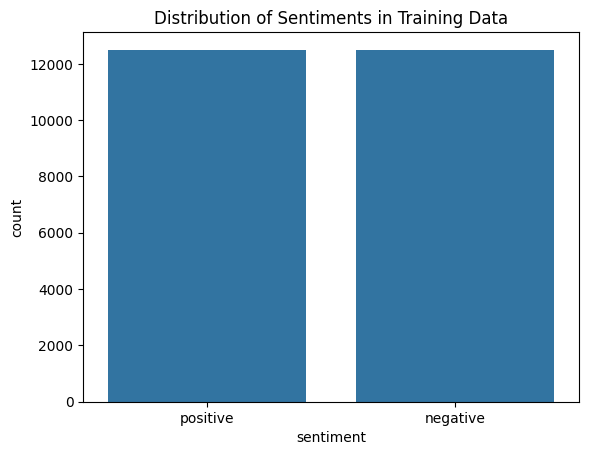

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

train_df.info()
train_df['sentiment'].value_counts()

sns.countplot(x='sentiment', data=train_df)
plt.title('Distribution of Sentiments in Training Data')
plt.show()

Berdasarkan output diatas, dapat diketahui bahwa dataset train terdiri dari **25000 baris dan 2 kolom**, dan distribusi label (sentimen) adalah **positive sebanyak 12500** dan **negatif sebanyak 12500**.

In [4]:
from wordcloud import WordCloud

def wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

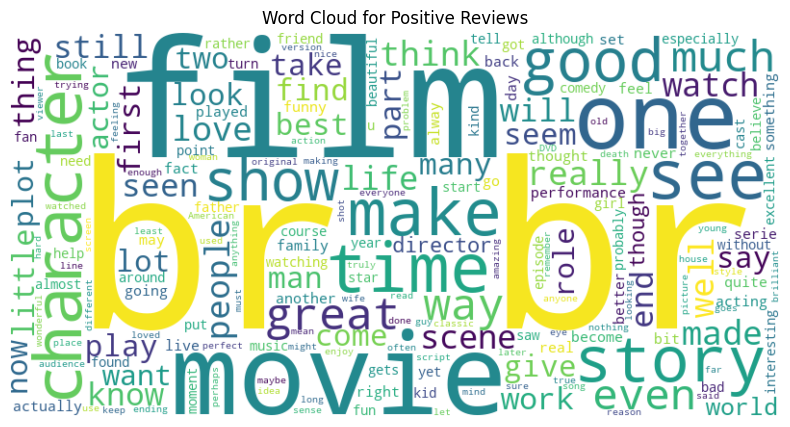

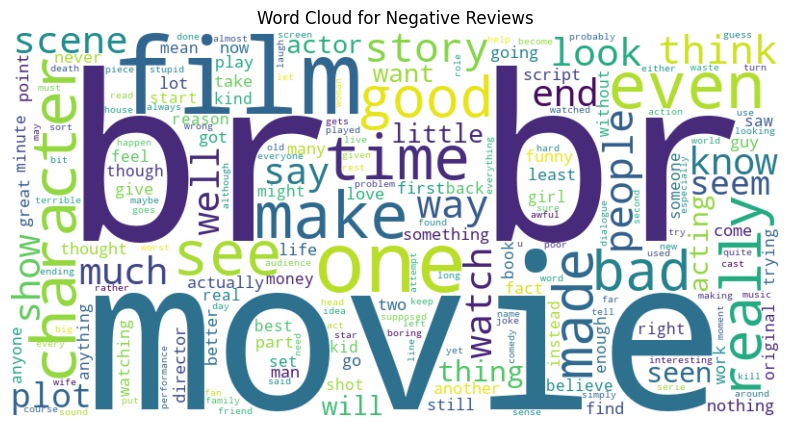

In [5]:
wordcloud(train_df[train_df['sentiment'] == 'positive']['review'], 'Word Cloud for Positive Reviews')
wordcloud(train_df[train_df['sentiment']=='negative']['review'], 'Word Cloud for Negative Reviews')

Berdasarkan hasil Word Cloud untuk review positif, dapat dilihat bahwa kata *br* menjadi kata terbanyak yang ada di review positif, diikuti dengan kata *film*, *movie*, *one*, *see*, *time*, *show*, *good*, *character*, *great*, *scene*, dan sebagainya.

Berdasarkan hasil Word Cloud untuk review negatif, dapat dilihat bahwa kata *br* menjadi kata terbanyak yang ada di review negatif, diikuti dengan kata *film*, *movie*, *one*, *make*, *even*, *acting*, *bad*, *really*, *rime*, dan sebagainya.

Terlihat bahwa kata *br* muncul sebagai kata terbanyak di review positif dan negatif. Dapat dipastikan ini adalah salah satu tag HTML yang sebaiknya dibersihkan dari teks. Beberapa kata lain, seperti *one*, *will*, *even*, *see*, *time*, *make*, dan kata umum lainnya masih sangat besar, ini tidak banyak memberi informasi terhadap sentimen dan harus dihapus melalui **stopwords removal**. Selain itu, terdapat juga beberapa kata yang belum distandarkan, seperti *seen*, *made*, *acting*, *watch*, dan kata lainnya, sehingga perlu **lemmatization** untuk mengembalikan kata-kata tersebut ke bentuk awal.

# Preprocessing Data
Pada tahap ini, akan dilakukan proses **cleansing** data dan **encoding** agar data siap untuk dimodelkan. 

## Cleansing

In [6]:
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<br\s*/?>', ' ', text)
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [7]:
train_df['clean_review'] = train_df['review'].apply(preprocess_text)
test_df['clean_review'] = test_df['review'].apply(preprocess_text)


Pertama-tama, data teks diubah menjadi huruf kecil untuk konsistensi. Selanjutnya, tag HTML seperti `<br>` dihapus menggunakan ekspresi reguler. Angka juga dihapus karena biasanya tidak memberikan informasi yang berguna dalam analisis sentimen. Tanda baca dihilangkan untuk menyederhanakan teks. Selain itu, kata "br" yang muncul sering kali sebagai hasil dari tag HTML juga dihapus. Terakhir, spasi ekstra dihapus untuk memastikan teks bersih dan rapi. Hasil dari preprocessing ini adalah teks yang lebih bersih dan siap untuk analisis lebih lanjut.

## Encoding

In [8]:
le = LabelEncoder()
train_df['sentiment_encoded'] = le.fit_transform(train_df['sentiment'])
test_df['sentiment_encoded'] = le.transform(test_df['sentiment'])

Selanjutnya data dilakukan proses encoding. Encoding pada data bertujuan untuk mengubah label teks (misalnya *positive*, *negative*) menjadi angka agar model machine learning dapat memprosesnya. Hal ini dilakukan karena algoritma SVM hanya dapat membaca nilai numerik, bukan string.

## Train-Test Split
Tahap ini dilakukan untuk membagi dataset menjadi beberapa bagian agar proses pelatihan model lebih terstruktur, objektif, dan dapat dievaluasi secara akurat. Data dibagi menjadi tiga bagian utama, yaitu **data training**, **data validation**, dan **data testing**.  

### Data Training  
Data training digunakan untuk **melatih model** dalam mengenali pola dari teks ulasan. Pada tahap ini, model belajar hubungan antara teks yang sudah dibersihkan (clean review) dengan label sentimen yang sesuai.

### Data Validation  

Data validation digunakan untuk **mengevaluasi performa model** selama proses pelatihan. Data ini membantu dalam melakukan penyesuaian parameter (*hyperparameter tuning*) serta memantau apakah model mengalami *overfitting* (terlalu menyesuaikan dengan data training) atau *underfitting* (belum cukup belajar pola data).

### Data Testing  

Data testing digunakan setelah proses pelatihan selesai. Tujuannya adalah untuk **mengukur kemampuan model** dalam memprediksi data baru yang belum pernah dilihat sebelumnya. Hasil dari tahap ini mencerminkan performa model secara keseluruhan dan kemampuannya untuk melakukan generalisasi.

In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    train_df['clean_review'],
    train_df['sentiment_encoded'],
    test_size=0.2,
    random_state=42,
    stratify=train_df['sentiment_encoded']
)

In [10]:
X_test = test_df['clean_review']
y_test = test_df['sentiment_encoded']


## Tokenization
Proses memecah teks jadi potongan-potongan kecil yang disebut token, biasanya berupa kata atau frasa. Tujuannya agar komputer dapat lebih mudah memahami isi teks. Dengan tokenisasi, setiap kata dapat dihitung, dianalisis, atau dijadikan fitur untuk model machine learning.

| Input | Output |
|----------------|---------|
| "I love eating red apples" | ["I", "love", "eating", "red", "apples"] |



In [11]:
import nltk
from nltk.tokenize import word_tokenize

word_token_train = [word_tokenize(i) for i in X_train]
word_token_val = [word_tokenize(i) for i in X_val]
word_token_test = [word_tokenize(i) for i in X_test]

## Stopword Removal
Stopwords removal adalah proses untuk menghapus kata-kata umum yang tidak terlalu penting, seperti *I*, *and*, atau *this*. Tujuannya agar data lebih bersih dan model dapat fokus ke kata yang bermakna, jadi kata yang hanya mengisi kalimat namun tidak menambah makna dapat dibuang.
| Input | Output |
|----------------|---------|
| ["I", "love", "eating", "red", "and", "green", "apples"] | ["love", "eating", "red", "green", "apples"] |


In [12]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

list(stop_words)[:20]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['mustn',
 'was',
 'below',
 'more',
 "should've",
 "they've",
 "couldn't",
 'most',
 'each',
 'if',
 'such',
 'a',
 'an',
 "haven't",
 'ma',
 'they',
 'didn',
 "doesn't",
 'until',
 'wasn']

In [13]:
filtered_tokens_train = [[word for word in sublist if word not in stop_words] for sublist in word_token_train]
filtered_tokens_val = [[word for word in sublist if word not in stop_words] for sublist in word_token_val]
filtered_tokens_test = [[word for word in sublist if word not in stop_words] for sublist in word_token_test]


## Lemmatization
Lemmatization adalah proses ubah kata ke bentuk dasarnya, tapi tetap melihat konteks dan maknanya. Tujuannya agar kata yang artinya sama akan dianggap sama juga oleh model. Dengan begitu, hasil analisis jadi lebih konsisten dan tidak membuat model kebingungan.
| Example Input | Output |
|----------------|---------|
| ["running", "ran", "runs"] | ["run", "run", "run"] |


In [14]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
lemmatized_tokens_train = [[lemmatizer.lemmatize(word) for word in sublist] for sublist in filtered_tokens_train]
lemmatized_tokens_val = [[lemmatizer.lemmatize(word) for word in sublist] for sublist in filtered_tokens_val]
lemmatized_tokens_test = [[lemmatizer.lemmatize(word) for word in sublist] for sublist in filtered_tokens_test]


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Text Representation

Tahap **text representation** adalah proses mengubah teks mentah jadi bentuk angka supaya bisa dipahami oleh model *machine learning*. Soalnya, model nggak bisa langsung “baca” teks seperti manusia. Jadi, tiap kata perlu diubah jadi angka yang menggambarkan seberapa penting kata itu dalam sebuah kalimat atau dokumen.

Di sini dipakai metode **TF-IDF (Term Frequency – Inverse Document Frequency)**. Sederhananya, TF-IDF menghitung seberapa sering sebuah kata muncul dalam satu teks (*term frequency*), lalu menyesuaikannya dengan seberapa jarang kata itu muncul di semua teks yang ada (*inverse document frequency*). Jadi kata yang terlalu sering muncul bakal punya bobot kecil, sedangkan kata yang lebih khas bakal punya bobot lebih besar.

TF-IDF dipilih karena bisa nunjukin kata-kata yang benar-benar punya pengaruh dalam menentukan sentimen positif atau negatif. Hasil akhirnya berupa angka-angka (matriks) yang mewakili pentingnya setiap kata di tiap teks, dan data inilah yang nanti dipakai sebagai input buat model *machine learning*.



In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()

X_train_tfidf = tfidf_vectorizer.fit_transform([' '.join(tokens) for tokens in lemmatized_tokens_train])
X_val_tfidf = tfidf_vectorizer.transform([' '.join(tokens) for tokens in lemmatized_tokens_val])
X_test_tfidf = tfidf_vectorizer.transform([' '.join(tokens) for tokens in lemmatized_tokens_test])



# Modeling and Evaluation


## Modeling

Linear SVM dipilih karena karakteristiknya sangat cocok untuk jenis dataset yang digunakan dalam proyek ini, yaitu **teks ulasan yang telah diubah menjadi representasi numerik menggunakan TF-IDF**. Dataset seperti ini umumnya memiliki jumlah fitur yang sangat besar, tetapi setiap dokumen hanya mengandung sebagian kecil dari semua kata yang mungkin muncul, yang artinya datanya **bersifat berdimensi tinggi dan jarang (sparse)**.

Dalam kondisi seperti ini, **Linear SVM unggul dibandingkan model lain** seperti *Naive Bayes*, *Logistic Regression*, atau *Random Forest* karena beberapa alasan berikut:

1. **Kinerja optimal pada data berdimensi tinggi**
   Linear SVM dirancang untuk bekerja sangat baik pada data dengan jumlah fitur besar, seperti hasil dari TF-IDF. Model ini fokus mencari *hyperplane* terbaik yang memisahkan dua kelas, tanpa harus memproses semua fitur secara eksplisit.

2. **Lebih tahan terhadap overfitting**
   Berbeda dengan model kompleks seperti *Random Forest* atau *Neural Network*, Linear SVM cenderung lebih stabil dan tidak mudah overfit karena memiliki kontrol yang baik melalui parameter *regularization (C)*.

3. **Cepat dan efisien**
   Untuk data teks dalam jumlah besar, Linear SVM jauh lebih efisien dalam waktu pelatihan dibanding model seperti model ensemble atau *deep learning*, yang membutuhkan komputasi berat.

4. **Akurasi tinggi untuk klasifikasi biner**
   Karena dataset ini memiliki dua label utama, Linear SVM sangat ideal karena model ini dirancang untuk menemukan batas tegas antara dua kelas.

5. **Konsisten dengan TF-IDF**
   Representasi TF-IDF menghasilkan data linear dan terdistribusi dengan baik, sehingga sangat cocok digunakan dengan Linear SVM yang menggunakan *fungsi kernel linear*. Kombinasi ini sering terbukti menghasilkan performa terbaik dalam analisis sentimen.

Secara keseluruhan, Linear SVM dipilih karena memberikan keseimbangan yang baik antara **akurasi, efisiensi, dan kemampuan generalisasi**, terutama pada dataset teks dengan jumlah fitur besar seperti milik proyek ini.

In [16]:
from sklearn.svm import LinearSVC
model = LinearSVC()

from sklearn.metrics import classification_report, confusion_matrix

model.fit(X_train_tfidf, y_train)

model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': 'auto',
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

## Evaluation

Accuracy on Validation Set: 0.8938

Classification Report on Validation Set:
               precision    recall  f1-score   support

    negative       0.90      0.89      0.89      2500
    positive       0.89      0.90      0.89      2500

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



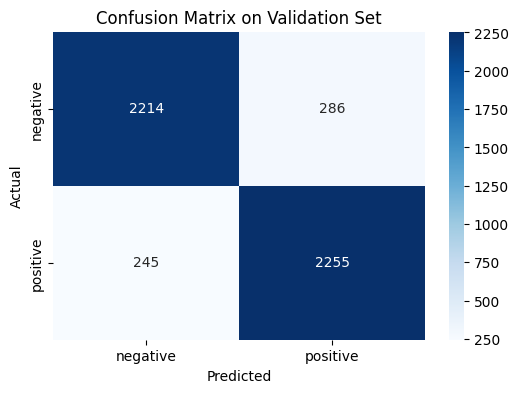

In [17]:
val_predictions = model.predict(X_val_tfidf)

print(f"Accuracy on Validation Set: {model.score(X_val_tfidf, y_val):.4f}")
print(f"\nClassification Report on Validation Set:\n {classification_report(y_val, val_predictions, target_names=le.classes_)}")

cm = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Validation Set')
plt.show()

Hasil evaluasi pada data validasi dapat dilihat bahwa model **Linear SVM** menghasilkan **akurasi sebesar 0.8938**. Nilai ini menunjukkan bahwa model mampu mengklasifikasikan ulasan positif dan negatif dengan tingkat ketepatan yang cukup tinggi.

Jika dilihat dari laporan klasifikasi:

* **Precision (ketepatan)** untuk kedua kelas berada di kisaran **0.89–0.90**, artinya ketika model memprediksi suatu ulasan sebagai positif atau negatif, sekitar 89–90% prediksi tersebut benar.
* **Recall (sensitivitas)** juga konsisten di kisaran **0.89–0.90**, yang berarti model berhasil mengenali hampir semua data positif dan negatif dengan baik.
* **F1-score** sebesar **0.89** untuk kedua kelas menunjukkan keseimbangan yang baik antara precision dan recall, menandakan model tidak terlalu bias ke salah satu kelas.

Hasil ini bisa dikatakan **stabil dan seimbang**, karena nilai precision, recall, dan f1-score hampir sama untuk kedua label. Ini menunjukkan bahwa model tidak hanya fokus pada satu kelas, misalnya hanya mengenali ulasan positif, tetapi juga cukup baik dalam mengenali ulasan negatif.

Accuracy on Test Set: 0.8672

Classification Report on Test Set:
               precision    recall  f1-score   support

    negative       0.86      0.88      0.87     12500
    positive       0.87      0.86      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



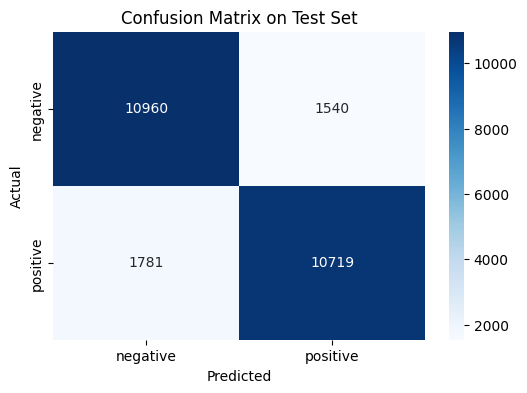

In [18]:
test_predictions = model.predict(X_test_tfidf)

print(f"Accuracy on Test Set: {model.score(X_test_tfidf, y_test):.4f}")
print(f"\nClassification Report on Test Set:\n {classification_report(y_test, test_predictions, target_names=le.classes_)}")

cm = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

Pada pengujian akhir menggunakan **data test**, model **Linear SVM** mencapai **akurasi sebesar 0.8672**. Hasil ini menunjukkan bahwa model tetap mampu mempertahankan performa yang baik ketika diuji pada data yang belum pernah dilihat sebelumnya, sehingga menandakan **kemampuan generalisasi yang cukup baik**.

Dari laporan klasifikasi:

* **Precision** untuk kelas positif dan negatif berada di kisaran **0.86–0.87**, artinya model jarang salah dalam memprediksi label sentimen.
* **Recall** juga seimbang di sekitar **0.86–0.88**, yang menunjukkan bahwa model berhasil mengenali sebagian besar data dari kedua kelas dengan baik.
* **F1-score** sebesar **0.87** menandakan keseimbangan yang stabil antara precision dan recall, menegaskan bahwa performa model konsisten di kedua kelas sentimen.

Performa ini sedikit lebih rendah dibandingkan hasil pada **data validasi (0.8938)**, tapi perbedaannya relatif kecil. Hal ini wajar karena data test digunakan untuk menguji kemampuan model menghadapi data baru yang tidak digunakan selama proses pelatihan maupun validasi.


Dari hasil pengujian **model awal Linear SVM**, didapatkan performa yang cukup tinggi, yaitu:

* **Akurasi validasi: 0.8938**
* **Akurasi data uji: 0.8672**

Performa ini menunjukkan bahwa model sudah **mampu mengenali pola sentimen dengan baik** dan memiliki **kemampuan generalisasi yang stabil** antara data validasi dan data uji. Artinya, model tidak mengalami overfitting yang parah dan bisa bekerja dengan baik pada data baru.

Namun, perbedaan kecil antara akurasi validasi dan test (sekitar 2%) menunjukkan bahwa masih ada ruang untuk peningkatan performa. Hal ini bisa dilakukan dengan melakukan **penyetelan hyperparameter (hyperparameter tuning)** pada model.

Proses tuning ini bertujuan untuk:

* Mencari kombinasi parameter terbaik seperti nilai **C** dan jenis **loss function**,
* Menyeimbangkan antara **margin yang optimal** dan **kesalahan klasifikasi**,
* Meningkatkan akurasi tanpa mengorbankan kemampuan generalisasi.

**Model dasar Linear SVM sudah kuat**, tapi melalui proses hyperparameter tuning, diharapkan hasilnya dapat **lebih optimal dan stabil**, terutama dalam membedakan sentimen positif dan negatif secara lebih akurat.


## Hyperparameter Tuning dengan Bayesian Optimization

*Bayesian Optimization* (`BayesSearchCV`) digunakan untuk mencari kombinasi hyperparameter terbaik secara lebih efisien dibanding *Grid Search* atau *Random Search*.  
Alih-alih mencoba semua kombinasi, metode ini **belajar dari hasil sebelumnya** dan **memperkirakan kombinasi parameter yang paling menjanjikan** untuk diuji selanjutnya.  

Keunggulannya:
- **Lebih cepat** – butuh lebih sedikit percobaan untuk menemukan hasil optimal.  
- **Lebih cerdas** – fokus pada area parameter dengan performa tinggi.  
- **Lebih efisien** – sering menghasilkan akurasi lebih baik dengan komputasi lebih rendah.  

Pada proyek ini, metode ini digunakan untuk mengoptimasi parameter SVM (`C`, `loss`, dan `class_weight`) secara efisien pada ruang pencarian yang luas.


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(1e+25), None, np.str_('squared_hinge')] before, using random point [np.float64(14006881788178.693), 'balanced', 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(2.748048480853357e+16), 'balanced', 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(1324192791886042.5), None, np.str_('squared_hinge')] before, using random point [np.float64(63808428501175.97), 'balanced', 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(1567191080.3783083), 'balanced', 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(1567191080.3783083), np.str_('balanced'), np.str_('squared_hinge')] before, using random point [np.float64(63808428501175.97), 'balanced', 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(0.20752631321450585), 'balanced', 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(75517704.53120379), None, np.str_('squared_hinge')] before, using random point [np.float64(407.1515547789694), None, 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(14006881788178.693), 'balanced', 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(3074715081321.8384), None, 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(344021326.3039766), None, np.str_('squared_hinge')] before, using random point [np.float64(1e+25), None, 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(0.945387283130794), None, 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(3638945.9900993896), None, 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(1.1835067295194714e+19), 'balanced', 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(798801.7808015702), None, np.str_('squared_hinge')] before, using random point [np.float64(344021326.3039766), 'balanced', 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(63808428501175.97), 'balanced', 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(1567191080.3783083), None, np.str_('squared_hinge')] before, using random point [np.float64(1.0577675602831825e+23), None, 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(798801.7808015702), None, np.str_('squared_hinge')] before, using random point [np.float64(0.945387283130794), 'balanced', 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(0.04555505605468025), None, 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(14006881788178.693), None, 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(1854.7811900706147), 'balanced', 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(5.391471540435098e+19), None, np.str_('squared_hinge')] before, using random point [np.float64(1.0577675602831825e+23), 'balanced', 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), np.str_('balanced'), np.str_('squared_hinge')] before, using random point [np.float64(0.01), 'balanced', 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), np.str_('balanced'), np.str_('squared_hinge')] before, using random point [np.float64(5.391471540435098e+19), None, 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(5.702923697662198e+17), None, 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(407.1515547789694), None, 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('hinge')] before, using random point [np.float64(344021326.3039766), 'balanced', 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(407.1515547789694), None, 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), np.str_('balanced'), np.str_('squared_hinge')] before, using random point [np.float64(2.3219542502889883e+22), 'balanced', 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(1324192791886042.5), None, 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(7139347751.502866), np.str_('balanced'), np.str_('squared_hinge')] before, using random point [np.float64(290679653713213.7), 'balanced', 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(32523338701.356945), np.str_('balanced'), np.str_('squared_hinge')] before, using random point [np.float64(1e+25), None, 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(2.5979700872256445e+18), 'balanced', 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(1.2518750258625293e+17), None, np.str_('squared_hinge')] before, using random point [np.float64(63808428501175.97), 'balanced', 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(5.702923697662198e+17), None, 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(38491.59021949685), None, 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(63808428501175.97), None, 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(1.0577675602831825e+23), None, 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), np.str_('balanced'), np.str_('squared_hinge')] before, using random point [np.float64(1567191080.3783083), None, 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(1854.7811900706147), np.str_('balanced'), np.str_('hinge')] before, using random point [np.float64(7139347751.502866), None, 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(5.391471540435098e+19), 'balanced', 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(2.456087882417329e+20), 'balanced', 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(75517704.53120379), 'balanced', 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(5.097028631688903e+21), 'balanced', 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(8449.466108283332), None, 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(32523338701.356945), None, 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(5.702923697662198e+17), 'balanced', 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(8449.466108283332), None, 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(2.748048480853357e+16), 'balanced', 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(1854.7811900706147), 'balanced', 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(1567191080.3783083), None, 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(175348.65500829593), 'balanced', 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(407.1515547789694), 'balanced', 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(4.306717067640519), None, 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(4.81866605015225e+23), None, 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(16577238.855893211), None, 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(1567191080.3783083), np.str_('balanced'), np.str_('squared_hinge')] before, using random point [np.float64(2.456087882417329e+20), 'balanced', 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(3074715081321.8384), None, 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(19.619273742801198), None, 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(2.456087882417329e+20), np.str_('balanced'), np.str_('squared_hinge')] before, using random point [np.float64(3638945.9900993896), 'balanced', 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(2.5979700872256445e+18), None, 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(4.306717067640519), 'balanced', 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(798801.7808015702), None, 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), None, np.str_('squared_hinge')] before, using random point [np.float64(0.20752631321450585), None, 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), np.str_('balanced'), np.str_('squared_hinge')] before, using random point [np.float64(1324192791886042.5), None, 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), np.str_('balanced'), np.str_('squared_hinge')] before, using random point [np.float64(0.01), None, 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), np.str_('balanced'), np.str_('squared_hinge')] before, using random point [np.float64(2.5979700872256445e+18), None, 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), np.str_('balanced'), np.str_('squared_hinge')] before, using random point [np.float64(1.2518750258625293e+17), 'balanced', 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), np.str_('balanced'), np.str_('squared_hinge')] before, using random point [np.float64(344021326.3039766), None, 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), np.str_('balanced'), np.str_('squared_hinge')] before, using random point [np.float64(175348.65500829593), 'balanced', 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), np.str_('balanced'), np.str_('squared_hinge')] before, using random point [np.float64(0.945387283130794), 'balanced', 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), np.str_('balanced'), np.str_('squared_hinge')] before, using random point [np.float64(4.81866605015225e+23), 'balanced', 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), np.str_('balanced'), np.str_('squared_hinge')] before, using random point [np.float64(2.3219542502889883e+22), None, 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), np.str_('balanced'), np.str_('squared_hinge')] before, using random point [np.float64(19.619273742801198), None, 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), np.str_('balanced'), np.str_('squared_hinge')] before, using random point [np.float64(14006881788178.693), None, 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), np.str_('balanced'), np.str_('squared_hinge')] before, using random point [np.float64(1.0577675602831825e+23), 'balanced', 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), np.str_('balanced'), np.str_('squared_hinge')] before, using random point [np.float64(0.04555505605468025), 'balanced', 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), np.str_('balanced'), np.str_('squared_hinge')] before, using random point [np.float64(1.1188722115874268e+21), None, 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), np.str_('balanced'), np.str_('squared_hinge')] before, using random point [np.float64(1.1188722115874268e+21), 'balanced', 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), np.str_('balanced'), np.str_('squared_hinge')] before, using random point [np.float64(0.20752631321450585), None, 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), np.str_('balanced'), np.str_('squared_hinge')] before, using random point [np.float64(407.1515547789694), None, 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), np.str_('balanced'), np.str_('squared_hinge')] before, using random point [np.float64(2.5979700872256445e+18), 'balanced', 'squared_hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\ACER\anaconda3\envs\nlp_cuda_env\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.float64(0.20752631321450585), np.str_('balanced'), np.str_('squared_hinge')] before, using random point [np.float64(75517704.53120379), 'balanced', 'hinge']
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters: OrderedDict({'C': 0.20752631321450585, 'class_weight': None, 'loss': 'squared_hinge'})
Accuracy on Validation Set: 0.8930

Classification Report on Validation Set:

              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      2500
    positive       0.88      0.90      0.89      2500

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



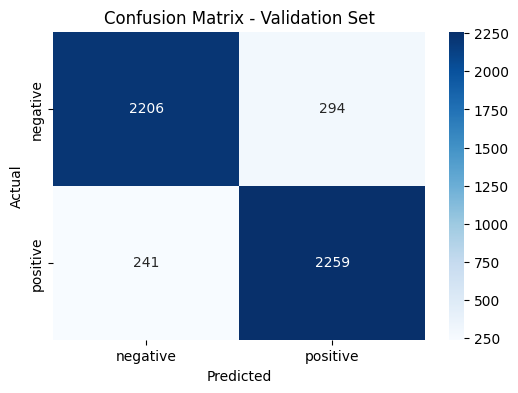

Accuracy on Test Set: 0.8778
Test Set Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



In [20]:
from skopt import BayesSearchCV
from sklearn.svm import LinearSVC
import numpy as np

svc = LinearSVC(max_iter=10000)

param_dist = {
    'C': np.logspace(-2, 25, 42),
    'loss': ['hinge', 'squared_hinge'],
    'class_weight': [None, 'balanced']
}

bayes_svc = BayesSearchCV(
    estimator=svc,
    search_spaces=param_dist,
    n_iter=200,
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

bayes_svc.fit(X_train_tfidf, y_train)

best_svc = bayes_svc.best_estimator_
print("Best parameters:", bayes_svc.best_params_)

val_predictions = best_svc.predict(X_val_tfidf)

print(f"Accuracy on Validation Set: {best_svc.score(X_val_tfidf, y_val):.4f}")
print("\nClassification Report on Validation Set:\n")
print(classification_report(y_val, val_predictions, target_names=le.classes_))

cm = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Validation Set')
plt.show()

print(f"Accuracy on Test Set: {best_svc.score(X_test_tfidf, y_test):.4f}")
y_test_pred = best_svc.predict(X_test_tfidf)
print("Test Set Classification Report:\n")
print(classification_report(y_test, y_test_pred))


## Evaluasi Hasil Hyperparameter Tuning

Setelah dilakukan **hyperparameter tuning** menggunakan metode `BayesSearchCV`, model *Linear SVM* berhasil menemukan kombinasi parameter terbaik, yaitu:

* **`C` = 0.0.208**
* **`loss` = ‘squared_hinge’**
* **`class_weight` = None**

Hasil evaluasi dari hyperparameter tuning adalah:

* **Akurasi pada data validasi:** 0.8930
* **Akurasi pada data uji:** 0.8778

Nilai akurasi dan metrik seperti *precision*, *recall*, dan *f1-score* menunjukkan hasil yang **seimbang antara kelas positif dan negatif**, masing-masing di sekitar 0.88–0.89. Ini menandakan model mampu mengenali kedua jenis sentimen secara konsisten tanpa bias dominan terhadap salah satu kelas.

Secara keseluruhan, performa model setelah tuning **tidak jauh berbeda dari base model**, hanya mengalami sedikit peningkatan pada data uji. Hal ini menunjukkan bahwa model awal *Linear SVM* sebenarnya sudah cukup optimal, dan proses tuning membantu **memperkuat kestabilan performa model** dengan parameter yang lebih sesuai.

Model *Linear SVM* dengan kernel linear tetap menjadi pilihan yang ideal untuk dataset ini karena:

* Dataset berukuran besar dan berdimensi tinggi hasil dari TF-IDF, di mana SVM linear sangat efisien.
* Data memiliki dua kelas yang relatif seimbang.
* TF-IDF menghasilkan vektor yang jarang (*sparse*), yang cocok dengan struktur matematis SVM.


## Kesimpulan Akhir

Dengan hasil ini, dapat disimpulkan bahwa **proses hyperparameter tuning membantu meningkatkan performa model dan mengurangi potensi overfitting**, meskipun peningkatannya tidak terlalu besar. Model akhir dengan parameter terbaik dapat digunakan untuk klasifikasi sentimen karena telah terbukti memiliki **akurasi tinggi, stabilitas yang baik, dan keseimbangan performa antar kelas**.

In [ ]:
import joblib

joblib.dump(best_svc, 'sentiment_model.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(le, 'label_encoder.pkl')

['label_encoder.pkl']